# Visualize predictions by all phages

In [22]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.cluster.hierarchy import linkage
from scipy.stats import mannwhitneyu, ttest_1samp, ttest_ind, ttest_rel
import seaborn as sns
import json
import pickle
import os

from sklearn.metrics import precision_recall_curve, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve, average_precision_score, f1_score
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

np.random.seed(0)

plt.rcParams['svg.fonttype'] = 'none'
sns.set_style("ticks")
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'arial'
plt.rcParams['font.size'] = '15'

base_dir = os.getcwd()
print(base_dir)

%matplotlib inline

/Users/lukas/Documents/Technische Universitaet Wien/Software & Information Engineering/Exzellenzprogramm/2. Semester (SS25)/Machine Learning Algorithms and Applications/project/prediction-of-phage-host-interactions/dev/predictions


In [23]:
# interaction_matrix = pd.read_csv("D:\\These\\20_data\\212_interaction_matrices\\ADSORPTION_MATRIX_370+host.csv", sep=";").set_index("bacteria")
interaction_matrix = pd.read_csv("../../data/interactions/interaction_matrix.csv", sep=";", na_values="NA").set_index("bacteria")

if "P" in interaction_matrix.values or "U" in interaction_matrix.values:
    interaction_matrix = interaction_matrix.replace({"N": 0, "P": 1, "F": np.nan, "U": 1})
    MODE = "QUALI"
else:
    MODE = "QUANTI"

print(f"Visualizing... {MODE} interaction matrix!")

phage_features = pd.read_csv("../../data/genomics/phages/guelin_collection.csv", sep=";").set_index("phage").loc[interaction_matrix.columns,]
bact_features = pd.read_csv("../../data/genomics/bacteria/picard_collection.csv", sep=";").set_index("bacteria")
# klesbiella_capsules = pd.read_csv("D:/These/30_dev/318_capsules/results/kaptive_results_high_hits_cured.txt", sep="\t").set_index("bacteria")

# Impose bacterial phylogenetic order and phage order in heatmap
interaction_matrix.loc["H1-005-0065-L-P"] = np.nan  # lost bacteria
interaction_matrix.loc["H27"] = np.nan  # lost bacteria
# bacteria_order = np.loadtxt("D:\\These\\20_data\\201_genomic_data\\370_and_host\\host\\panacota\\Tree\\ordered_tree_leaves_370+host_origname.txt", delimiter=",", dtype=str)[::-1]  # load bacteria order

# add phage features group size
# force_phage_order = {"Dhakavirus": 0, "Mosigvirus": 1, "Krischvirus": 2, "Tequatrovirus": 3, "Felixounavirus": 4, "Wifcevirus": 5, "Justusliebigvirus": 6, "Phapecoctavirus": 7, "Gamaleyavirus": 8, "Teseptimavirus": 9, "Przondovirus": 10, "Kayfunavirus": 11, "Vectrevirus": 12, "Veterinaerplatzvirus": 13, "Kagunavirus": 14, "Lambdavirus": 15, "Sashavirus": 16, "Wanchaivirus": 17, "Dhillonvirus": 18}
# phage_features["order"] = phage_features["Genus"].apply(lambda x: force_phage_order[x])
# phage_features = phage_features.reset_index().rename({"index": "phage"}, axis=1).sort_values(["order", "phage"]).set_index("phage")

# interaction_matrix = interaction_matrix.loc[bacteria_order, phage_features.index]  # force phylogenetic ordering in the matrix

print(interaction_matrix.shape, phage_features.shape)

Visualizing... QUANTI interaction matrix!
(404, 96) (96, 10)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

perf_dir = f"{base_dir}/outputs/results/performances"

# get best models for each phage
best_models = []
for p in phage_features.index:
    try:
        perf = pd.read_csv(perf_dir + f"/performance_{p}_Group10Fold_CV.csv", sep=";")
    except FileNotFoundError:
        continue

    # get best model on test set
    perf_by_model = perf.loc[perf["dataset"] == "test"].groupby("model")["avg_precision"].mean()
    best_model = perf_by_model.sort_values(ascending=False).index[0]

    best_models.append({"phage": p, "model": best_model})
best_models = pd.DataFrame(best_models)

# Get predictions by the best model for each phage
preds_dir = f"outputs/results/predictions"
preds = []
for p in os.listdir(preds_dir):
    preds.append(pd.read_csv(preds_dir + "/" + p, sep=";"))
all_predictions = pd.concat(preds, axis=0)

all_predictions = pd.merge(all_predictions, best_models, on=["phage", "model"])

# Get predictions on test set for each phage
predictions = all_predictions.loc[all_predictions["dataset"] == "test"]

# Get unique classes
classes = np.unique(predictions["y"])
# Compute confusion matrix
cm = confusion_matrix(predictions["y"], predictions["y_pred"], labels=classes)
print("Confusion Matrix:")
print(cm)

# Classification report (precision, recall, f1 per class)
report = classification_report(predictions["y"], predictions["y_pred"], labels=classes)
print("Classification Report:")
print(report)

# Compute macro/micro average AUROC if probabilities are available and >2 classes
if len(classes) > 2:
    try:
        y_true = predictions["y"]
        y_score = predictions[[col for col in predictions.columns if col.startswith("y_pred_proba")]]
        roc_auc = roc_auc_score(y_true, y_score, multi_class="ovr", average="macro")
        print("Macro AUROC:", roc_auc)
    except Exception as e:
        print("AUROC could not be computed for multi-class:", e)
else:
    roc_auc = roc_auc_score(predictions["y"], predictions["y_pred_proba"])
    print("AUROC:", roc_auc)

Confusion Matrix:
[[7780 1094  968  607  598]
 [1086  299  212  167  169]
 [ 971  195  229  153  141]
 [ 631  175  123  102   89]
 [ 547  143  147   94  100]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.70      0.71     11047
         1.0       0.16      0.15      0.16      1933
         2.0       0.14      0.14      0.14      1689
         3.0       0.09      0.09      0.09      1120
         4.0       0.09      0.10      0.09      1031

    accuracy                           0.51     16820
   macro avg       0.24      0.24      0.24     16820
weighted avg       0.51      0.51      0.51     16820

AUROC could not be computed for multi-class: Target scores need to be probabilities for multiclass roc_auc, i.e. they should sum up to 1.0 over classes


In [5]:
predictions = all_predictions.loc[all_predictions["dataset"] == "test"]

# Performance
tn, fp, fn, tp = confusion_matrix(predictions["y"], predictions["y_pred"]).ravel()
precision, recall, f1 = precision_score(predictions["y"], predictions["y_pred"]), recall_score(predictions["y"], predictions["y_pred"]), f1_score(predictions["y"], predictions["y_pred"])
average_prec = average_precision_score(predictions["y"], predictions["y_pred_proba"])
roc_auc = roc_auc_score(predictions["y"], predictions["y_pred_proba"])

print(tp, fp, tn, fn)
print(precision, recall, f1)
print(average_prec)
print(roc_auc)

print("\n")

2491 3305 7727 3276
0.4297791580400276 0.4319403502687706 0.430857044019718
0.3796059314018496
0.5646613590515817




In [7]:
from bokeh.models import BasicTicker, PrintfTickFormatter, HoverTool
from bokeh.plotting import figure, show
from bokeh.sampledata.unemployment1948 import data
from bokeh.transform import linear_cmap
from bokeh.io import export_svg

def get_score(y_pred, y_true):
    if y_pred == 0 and y_true == 0:
        return 0  # TN
    elif y_pred == 0 and y_true == 1:
        return -1  # FN
    elif y_pred == 1 and y_true == 1:
        return 1  # TP
    elif y_pred == 1 and y_true == 0:
        return 2  # FP
    else:
        raise ValueError(f"y_pred and y_true should be either 0 or 1! y_pred={y_pred} and y_true={y_true} passed.")

# reshape to 1D array with one phage-bacteria interaction per line
df = predictions.copy()
scores = []
for i, row in predictions.iterrows():
    scores.append(get_score(row["y_pred"], row["y"]))
df["score"] = scores

# sort bacteria and phages
df = df.set_index("bacteria")

# add bacterial and phage genomic features
df = pd.merge(left=df, right=bact_features[["Clermont_Phylo", "ST_Warwick", "LPS_type", "O-type", "H-type", "Klebs_capsule_type", "ABC_serotype"]], left_on="bacteria", right_index=True)
df = pd.merge(left=df, right=phage_features[["Morphotype", "Genus", "Phage_host"]], left_on="phage", right_index=True)
df = df.rename({"O-type": "O", "H-type": "H"}, axis=1).reset_index()

bacteria = np.loadtxt("../../data/genomics/bacteria/isolation_strains/panacota/tree/ordered_tree_leaves_370+host_origname.txt", delimiter=",", dtype=str)[::-1]  # load bacteria order
phages = list(phage_features.index)

# Choose colormap that suits the interaction matrix type
# colors = sns.color_palette(["#00A6EE", "#f8f9fa", "#FCC500", "#DC3220"]).as_hex()
colors = sns.color_palette(["#B1AFAF", "#ffffff", "#214D96", "#A33C3C"]).as_hex()

# Display image and genomic features in hover
hover = """
    <div>
        <div>
            <span style="font-size: 15px; font-weight: bold;">@bacteria vs. @phage</span>
        </div>
        <div>
            <span style="font-size: 14px; color: #119; font-weight: bold;">y_pred=@y_pred vs. y=@y</span>
        </div>
        <div>
            <span style="font-size: 14px; color: #119; font-weight: bold;">@model</span>
        </div>
        <div>
            <span style="font-size: 10px; color: #911;">Phylogroup: @Clermont_Phylo \n</span>
        </div>
        <div>
            <span style="font-size: 10px; color: #911;">ST: @ST_Warwick \n</span>
        </div>
        <div>
           <span style="font-size: 10px; color: #911;">LPS: @LPS_type \n</span>
        </div>
        <div>
           <span style="font-size: 10px; color: #911;">O-type: @O \n</span>
        </div>
        <div>
             <span style="font-size: 10px; color: #911;">H-type: @H \n</span>
        </div>
        <div>
             <span style="font-size: 10px; color: #911;">Klebs K-type: @Klebs_capsule_type \n</span>
        </div>
        <div>
             <span style="font-size: 10px; color: #911;">ABC K-type: @ABC_serotype \n</span>
        </div>
        <div>
             <span style="font-size: 10px; color: #195;">Morphotype: @Morphotype \n</span>
        </div>
        <div>
             <span style="font-size: 10px; color: #195;">Genus: @Genus \n</span>
        </div>
        <div>
             <span style="font-size: 10px; color: #195;">Isolation host: @Phage_host \n</span>
        </div>
    </div>
"""

TOOLS = "hover,save,pan,box_zoom,reset,wheel_zoom"

p = figure(title="",#f"Adsorption factors + Core genome @ 1e-4\nPrecision={round(precision, 2)}, Recall={round(recall, 2)}, AvPrecision={round(average_prec, 2)}",
           x_range=bacteria, y_range=phages[::-1],
           x_axis_location="above", width=1500, height=700, tools=TOOLS,
           tooltips=hover)

p.grid.grid_line_color = None
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.axis.major_label_text_font_size = "7px"
p.axis.major_label_standoff = 0
p.xaxis.major_label_orientation = np.pi / 3
p.axis.visible = False

r = p.rect(x="bacteria", y="phage", width=1, height=1, source=df,
           fill_color=linear_cmap("score", colors, low=-1, high=2),
           line_color="#dddddd", line_width=0.25)

# p.add_layout(r.construct_color_bar(
#     major_label_text_font_size="7px",
#     ticker=BasicTicker(desired_num_ticks=len(colors)),
#     # formatter=PrintfTickFormatter(format="%d%"),
#     label_standoff=6,
#     border_line_color=None,
#     padding=5
# ), 'right')

# show figure or export it in svg format
do_export_figure = False
if do_export_figure:
    p.output_backend = "svg"
    export_svg(p, filename="D:/These/50_quotidien/50_papers/2023_coli/figures/Figure 5 - Prediction matrix/images/prediction_matrix.svg")
    # export_png(p, filename="D:\\These\\20_data\\213_data_nico\\cml_matrix_root=albertii.png")
else:
    show(p)

In [9]:
# Feature importance for each phage-specific model
fp = pd.read_csv(f"{base_dir}/outputs/results/feature_importances/T7_Portugal_feature_importance.csv", sep=";")

fig, ax = plt.subplots(1, 1, figsize=(20, 8))
bx = sns.boxplot(data=fp.sort_values("average_importance", ascending=False)[:200], x="variable", y="value", ax=ax, palette="Set2", hue="variable")
t = ax.set_xticklabels(bx.get_xticklabels(), rotation=60)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/lukas/Documents/Technische Universitaet Wien/Software & Information Engineering/Exzellenzprogramm/2. Semester (SS25)/Machine Learning Algorithms and Applications/project/prediction-of-phage-host-interactions/dev/predictions/outputs/results/feature_importances/T7_Portugal_feature_importance.csv'

### Performance per phage

In [10]:
perf = []
for p, pred in df.groupby("phage"):
    y_pred, y_pred_proba, y_true = pred["y_pred"], pred["y_pred_proba"], pred["y"]
    n_infections = pred["y"].sum()
    prec, rec, auc = precision_score(y_true, y_pred), recall_score(y_true, y_pred), roc_auc_score(y_true, y_pred_proba)
    perf.append({"phage": p, "n_infections": n_infections,  "precision": prec, "recall": rec, "auc": auc})
perf = pd.DataFrame(perf)

perf["model"] = "AF"

do_save = False
if do_save:
    perf.to_csv("per_phage_perf.csv", sep=",", index=False)

perf

,phage,n_infections,precision,recall,auc,model
0,427_P2,44.0,0.060606,0.045455,0.518886,AF
1,536_P1,175.0,0.454082,0.508571,0.503175,AF
2,536_P6,116.0,0.258333,0.267241,0.458333,AF
3,536_P7,245.0,0.631579,0.587755,0.475406,AF
4,536_P9,242.0,0.561753,0.582645,0.498528,AF
5,55989_P2,213.0,0.507317,0.488263,0.533090,AF
6,AL505_Ev3,158.0,0.375000,0.379747,0.481540,AF
7,AN17_P8,60.0,0.106061,0.116667,0.485294,AF
8,AN24_P2,5.0,0.000000,0.000000,0.496203,AF
9,AN24_P3,7.0,0.000000,0.000000,0.479275,AF


### Compare performance on train vs. test set

In [11]:
train_test_perf, train_test_diff = [], []
for g, grp in all_predictions.groupby(["phage", "fold"]):
    train_obs, test_obs = grp.loc[grp["dataset"] == "train"], grp.loc[grp["dataset"] == "test"]
    try:
        train_prec, train_rec, train_auc = precision_score(train_obs["y"], train_obs["y_pred"]), recall_score(train_obs["y"], train_obs["y_pred"]), roc_auc_score(train_obs["y"], train_obs["y_pred_proba"])
        test_prec, test_rec, test_auc = precision_score(test_obs["y"], test_obs["y_pred"]), recall_score(test_obs["y"], test_obs["y_pred"]), roc_auc_score(test_obs["y"], test_obs["y_pred_proba"])
        train_test_perf.append({"phage": g[0], "fold": g[1], "dataset": "train", "precision": train_prec, "recall": train_rec, "auc": train_auc})
        train_test_perf.append({"phage": g[0], "fold": g[1], "dataset": "test", "precision": test_prec, "recall": test_rec, "auc": test_auc})
        train_test_diff.append({"phage": g[0], "fold": g[1], "precision": train_prec - test_prec, "recall": train_rec - test_rec, "auc": train_auc - test_auc})
    except:
        train_test_perf.append({"phage": g[0], "fold": g[1], "dataset": "train", "precision": np.nan, "recall": np.nan, "auc": np.nan})
        train_test_perf.append({"phage": g[0], "fold": g[1], "dataset": "test", "precision": np.nan, "recall": np.nan, "auc": np.nan})
        train_test_diff.append({"phage": g[0], "fold": g[1], "precision": np.nan, "recall": np.nan, "auc": np.nan})
train_test_perf = pd.DataFrame(train_test_perf)
train_test_diff = pd.DataFrame(train_test_diff)

train_test_diff["auc"] = train_test_diff["auc"] * 100  # percentage

train_test_diff

,phage,fold,precision,recall,auc
0,427_P2,0,-0.152439,0.003175,-6.153354
1,427_P2,1,0.175000,0.175000,3.371212
2,427_P2,2,0.044444,0.046512,5.245956
3,427_P2,3,0.130435,0.142857,3.623017
4,427_P2,4,0.148936,0.184211,6.699025
...,...,...,...,...,...
415,T7_Portugal,5,0.074534,0.099078,-3.463972
416,T7_Portugal,6,0.203704,0.183333,4.193608
417,T7_Portugal,7,0.213115,0.206349,-8.248316
418,T7_Portugal,8,0.125000,0.096774,-5.459852


In [12]:
# Statistical test for overfitting
train_test_perf = train_test_perf.sort_values(["phage", "fold", "dataset"])

all_pv = []
for p, grp in train_test_perf.groupby("phage"):
    train, test = grp.loc[grp["dataset"] == "train"].dropna().rename({"auc": "train_auc"}, axis=1), grp.loc[grp["dataset"] == "test"].dropna().rename({"auc": "test_auc"}, axis=1)
    all_perf = pd.merge(train, test, on="fold")
    t, pval = ttest_ind(all_perf["train_auc"], all_perf["test_auc"])

    correct_pval = True
    if correct_pval:
        all_pv.append({"phage": p, "t": t, "p": pval*96})
    else:
        all_pv.append({"phage": p, "t": t, "p": pval*96})
all_pv = pd.DataFrame(all_pv)

print("#phages with significant association:", all_pv.loc[all_pv["p"] < 0.01].shape[0])

all_pv

#phages with significant association: 0


/Users/lukas/Documents/Technische Universitaet Wien/Software & Information Engineering/Exzellenzprogramm/2. Semester (SS25)/Machine Learning Algorithms and Applications/project/prediction-of-phage-host-interactions/.venv/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


,phage,t,p
0,427_P2,0.156874,84.200646
1,536_P1,-0.613981,52.503381
2,536_P6,1.878240,7.357992
3,536_P7,1.040652,29.934169
4,536_P9,0.022128,94.328542
5,55989_P2,-1.608042,12.021573
6,AL505_Ev3,0.625356,51.800219
7,AN17_P8,0.996828,31.877816
8,AN24_P2,-2.937958,2.497593
9,AN24_P3,2.236202,4.734812


0.5672198407152858


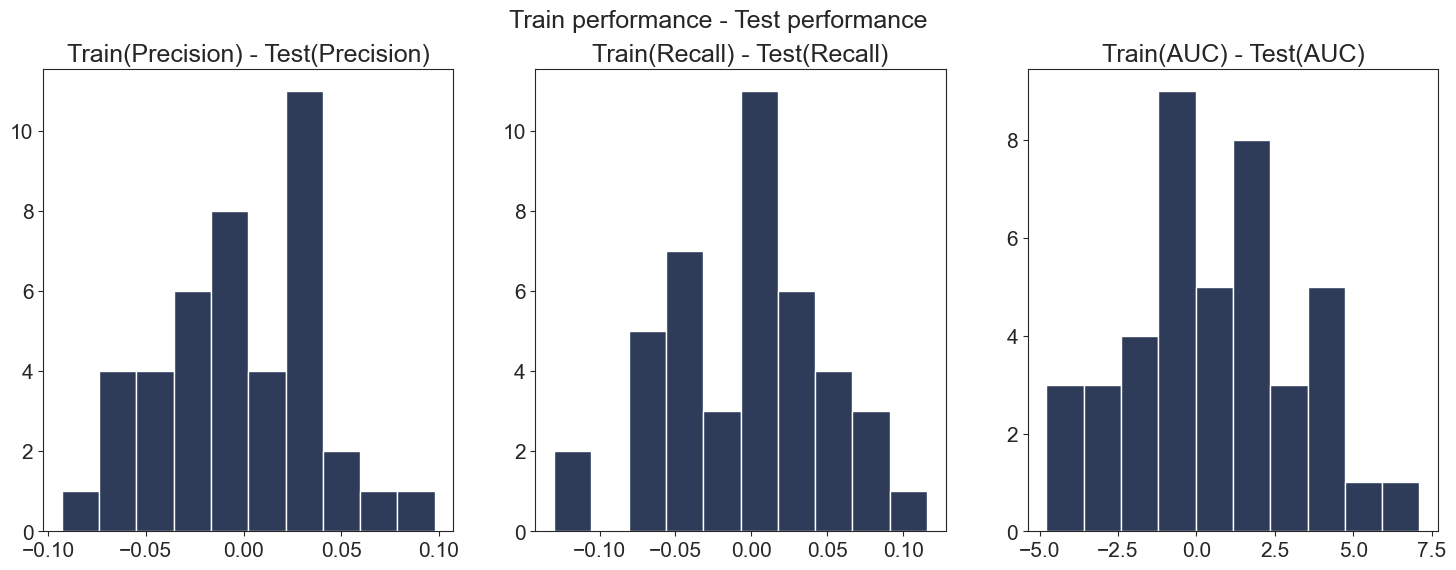

In [13]:
averaged_per_phage = train_test_diff.groupby("phage").mean()

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].hist(x=averaged_per_phage["precision"], color="#2E3C5A")
ax[0].set_title("Train(Precision) - Test(Precision)")
ax[1].hist(x=averaged_per_phage["recall"], color="#2E3C5A")
ax[1].set_title("Train(Recall) - Test(Recall)")
ax[2].hist(x=averaged_per_phage["auc"], color="#2E3C5A")
ax[2].set_title("Train(AUC) - Test(AUC)")

fig.suptitle("Train performance - Test performance")
print(train_test_diff["auc"].mean())

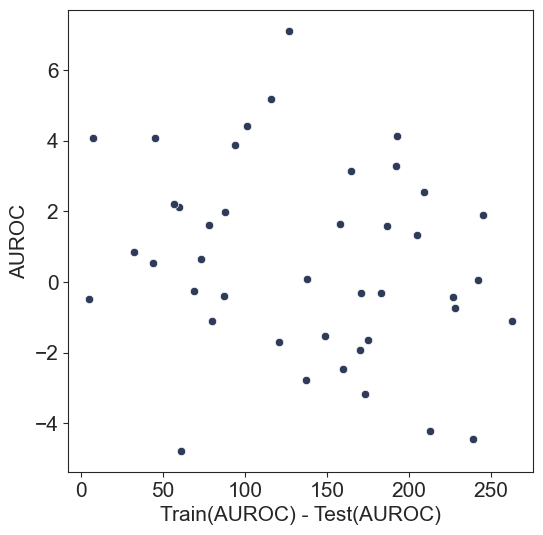

In [14]:
# Test AUC a.a.f.o (Train-Test AUC) 
n_infect = predictions.groupby("phage")["y"].sum()

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
to_plot = pd.merge(averaged_per_phage.rename({"auc": "train_test_auc"}, axis=1), perf, on="phage")
sns.scatterplot(data=to_plot, x="n_infections", y="train_test_auc", color="#2E3C5A")
ax.set_xlabel("Train(AUROC) - Test(AUROC)")
ax.set_ylabel("AUROC")

do_save = False
if do_save:
    plt.savefig("D:/These/50_quotidien/50_papers/2023_coli/figures/Figure 4 - Inference bacteria/data/overfitting/overfitting_vs_prevalence.svg")

In [15]:
averaged_per_phage["train_test_auc"] = averaged_per_phage["auc"]
averaged_per_phage["n_infections"] = n_infect

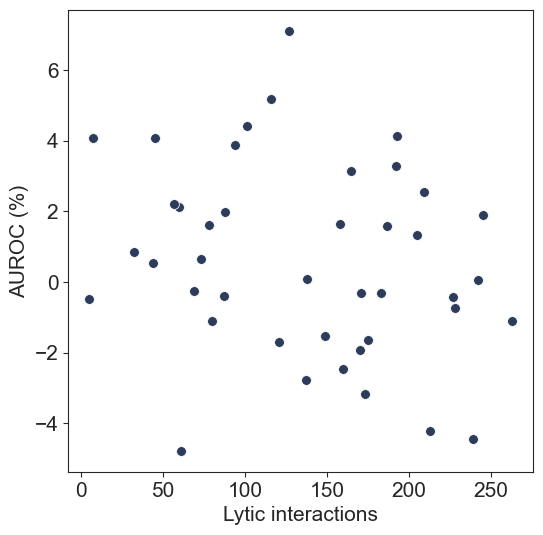

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.scatterplot(data=averaged_per_phage, x="n_infections", y="train_test_auc", ax=ax, color="#2D3C5A", s=50)
ax.set_xlabel("Lytic interactions")
ax.set_ylabel("AUROC (%)")

do_save = False
if do_save:
    plt.savefig("D:/These/50_quotidien/50_papers/2023_coli/figures/Figure 5 - Predictions/data/analyze_ML_results/train_test_auc_vs_prevalence.svg")

### Performance on test set

Text(0.5, 1.0, 'AUC')

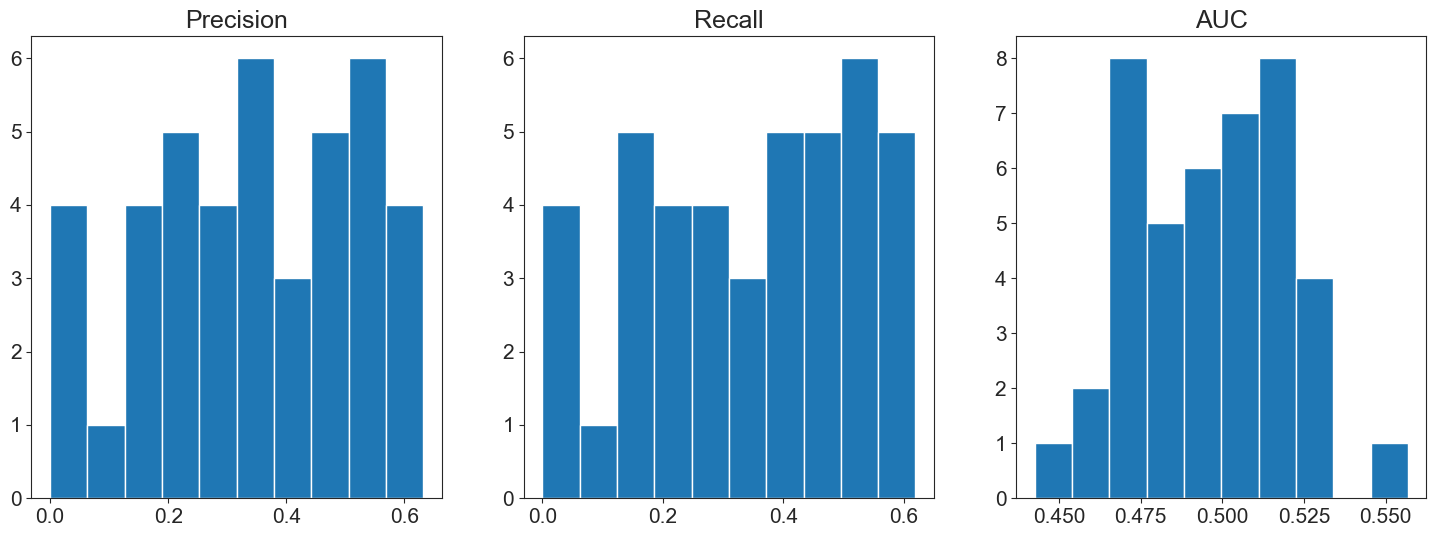

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].hist(x=perf["precision"])
ax[0].set_title("Precision")
ax[1].hist(x=perf["recall"])
ax[1].set_title("Recall")
ax[2].hist(x=perf["auc"])
ax[2].set_title("AUC")

FileNotFoundError: [Errno 2] No such file or directory: 'D:/These/50_quotidien/50_papers/2023_coli/figures/Figure 5 - Predictions/data/analyze_ML_results/auc_distrib.svg'

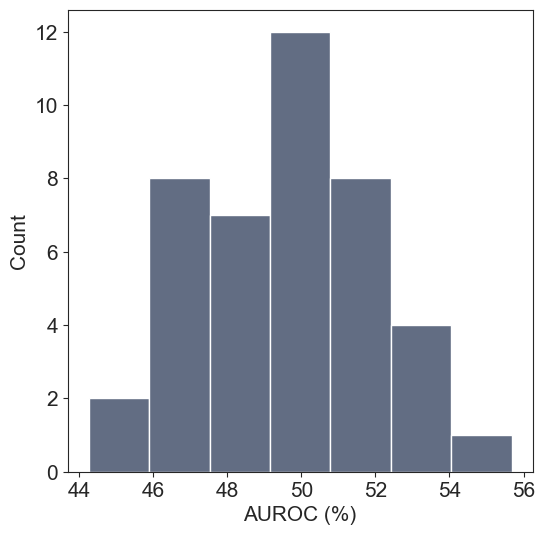

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
perf["auc"] = perf["auc"] * 100
sns.histplot(data=perf, x="auc", ax=ax, color="#2D3C5A")
ax.set_xlabel("AUROC (%)")
plt.savefig("D:/These/50_quotidien/50_papers/2023_coli/figures/Figure 5 - Predictions/data/analyze_ML_results/auc_distrib.svg")

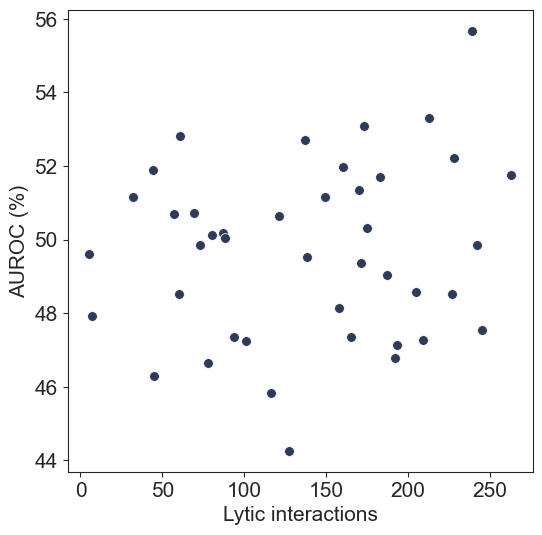

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.scatterplot(data=perf, x="n_infections", y="auc", ax=ax, color="#2D3C5A", s=50)
ax.set_xlabel("Lytic interactions")
ax.set_ylabel("AUROC (%)")

do_save = False
if do_save:
    plt.savefig("D:/These/50_quotidien/50_papers/2023_coli/figures/Figure 5 - Predictions/data/analyze_ML_results/auc_vs_prevalence.svg")

0.5646613590515817


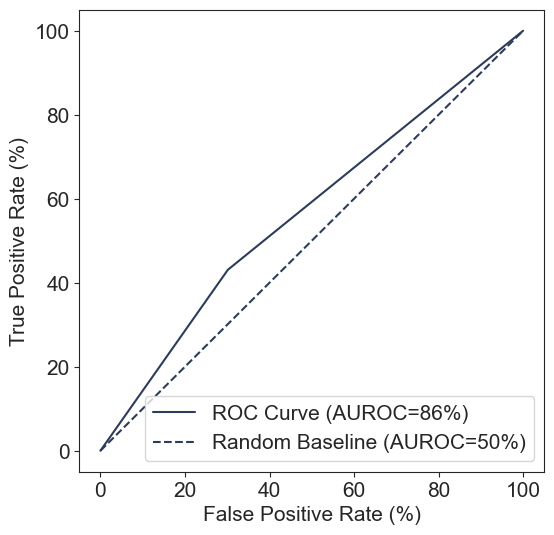

In [20]:
fpr, tpr, thresh = roc_curve(predictions["y"], predictions["y_pred_proba"])
auc_score = roc_auc_score(predictions["y"], predictions["y_pred_proba"])
print(auc_score)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(fpr*100, tpr*100, c="#2D3C5A", label="ROC Curve (AUROC=86%)")
ax.plot(np.linspace(0, 100, 10), np.linspace(0, 100, 10), "--", c="#2D3C5A", label="Random Baseline (AUROC=50%)")
ax.legend()
ax.set_xlabel("False Positive Rate (%)")
ax.set_ylabel("True Positive Rate (%)")

do_save = False
if do_save:
    plt.savefig("D:/These/50_quotidien/50_papers/2023_coli/figures/Figure 5 - Predictions/data/analyze_ML_results/roc_curve.svg")

Text(0.5, 1.0, 'AUC')

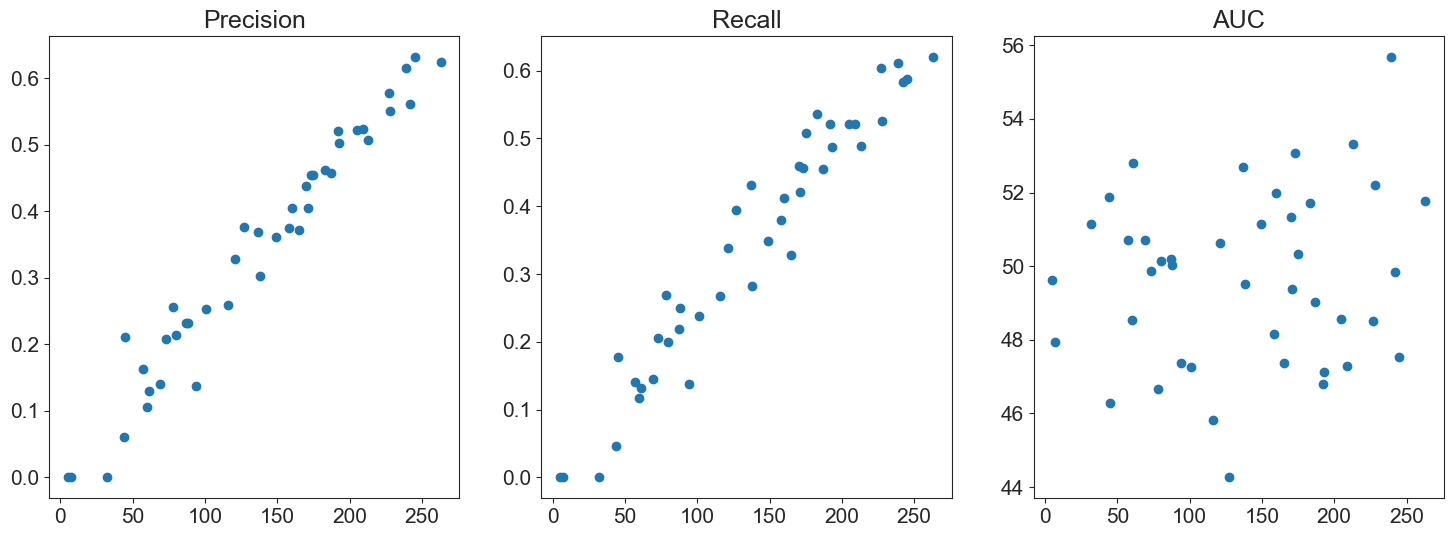

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].scatter(x=perf["n_infections"], y=perf["precision"])
ax[0].set_title("Precision")
ax[1].scatter(x=perf["n_infections"], y=perf["recall"])
ax[1].set_title("Recall")
ax[2].scatter(x=perf["n_infections"], y=perf["auc"])
ax[2].set_title("AUC")